# Today's at the moment stock data analysis

For my project I wanted to look at today's at the moment stock data and find out the top 5 largest stock by volume at the particular time and using yfinance get the information about those stocks and thru data visualization see how that stock is performing for the past year. I wanted to see when was the highest high, lowest low, when was the closing price of the data high n low as well as the opening price of the data. 


I am using yfinance which is built in on yahoo finance API for my analysis and for my visualisation I am using plotly as I am plotting interactive data.

In [29]:
import yfinance as yf
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.express as px


# to print current time and a day of the week and formatted
date = pd.Timestamp(datetime.datetime.today())
today = f"{date.day_name()} {date.strftime('%m-%d-%y %H:%M:%S')} "
today
#print(f"Today is {today.day_name()} {today.strftime('%m-%d-%y %H:%M:%S')} ")



'Saturday 03-25-23 23:46:36 '

In [30]:
def convert_scale(x):
    if type(x) == float or type(x) == int:
        return x
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000
        return 1000.0
    elif 'B' in x:
        if len(x) > 1:
            return float(x.replace('B', '')) * 1000000000
        return 1000000.0
    elif 'T' in x:
        return float(x.replace('T', '')) * 1000000000000
    else:
        return float(x)

## Feature 1: Loading Data
As per the requirement, 2 data sets to be loaded in. I decided to use pandas, read_html function which reads HTML tables into a list of DataFrame objects. I am reading in the tables from https://finance.yahoo.com/. From there, I am webscraping most-active, gainers and losers tables. 
The default filters used on the links.
1. most-active
    Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 5000000
2. gainers
    % Change in Price (Intraday):greater than 3, Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 15000
3. losers
    % Change in Price (Intraday):less than -2.5, Region: United States, Market Cap (Intraday): Mid Cap and Large Cap and Mega Cap, Volume:greater than 20000

We imported the Pandas module.
Using the read_html() method and passing the URL, we’ll get all the HTML tables from the website. Keep in mind the read_html() method returns a list.
Since we got a list holding the tables, we need to access the first element on the list, then we can pass the data as argument to the Pandas Dataframe() method to create our data set.

In [55]:
# reading in from a website and getting only the 1st page
most_active = pd.read_html('https://finance.yahoo.com/most-active')[0]
print(most_active.shape) #shows the shape of table
most_active.head() #print first 5 rows


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,TSLA,"Tesla, Inc.",190.4100,-1.8100,-0.94%,116.532M,180.633M,602.476B,50.51,NaN
1,BAC,Bank of America Corporation,27.1400,0.1700,+0.63%,96.333M,53.081M,217.1B,8.45,NaN
2,FRC,First Republic Bank,12.3600,-0.1700,-1.36%,72.124M,25.343M,2.302B,1.48,NaN
3,F,Ford Motor Company,11.5100,0.0900,+0.79%,71.418M,68.951M,45.881B,NaN,NaN
4,CS,Credit Suisse Group AG,0.8612,-0.0107,-1.23%,62.982M,46.328M,3.394B,NaN,NaN


In [32]:
# reading in 2nd table
gainers = pd.read_html('https://finance.yahoo.com/gainers')[0]
print(gainers.shape)
gainers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,RNW,ReNew Energy Global Plc,5.36,0.97,+22.10%,3.928M,1.055M,2.077B,NaN,NaN
1,PROK,ProKidney Corp.,12.62,1.67,+15.25%,432713,201780,2.937B,NaN,NaN
2,HSAI,Hesai Group,16.23,2.13,+15.11%,328974,668370,2.037B,NaN,NaN
3,BBIO,"BridgeBio Pharma, Inc.",14.90,1.32,+9.72%,9.502M,2.849M,2.387B,NaN,NaN
4,BAK,Braskem S.A.,6.82,0.53,+8.43%,1.445M,671860,2.865B,7.66,NaN


In [33]:
# reading in 3rd table
losers = pd.read_html('https://finance.yahoo.com/losers')[0]
print(losers.shape)
losers.head()


(25, 10)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,GTLB,GitLab Inc.,33.74,-3.1900,-8.64%,4.381M,2.663M,5.1B,NaN,NaN
1,EGFEY,Eurobank Ergasias Services and Holdings S.A.,0.64,-0.0589,-8.43%,25725,43229,4.784B,3.76,NaN
2,NEO,"NeoGenomics, Inc.",16.87,-1.2900,-7.10%,1.56M,1.063M,2.15B,NaN,NaN
3,LKNCY,Luckin Coffee Inc.,23.73,-1.7500,-6.87%,5.46M,1.734M,6.291B,118.65,NaN
4,ARRY,"Array Technologies, Inc.",18.47,-1.3400,-6.76%,6.153M,4.985M,2.785B,NaN,NaN


## Feature 2: Clean and operate on the data while combining them.
Next requirement for the project is to combine the datasets to create new dataset and do analysis on it. By looking at the tables, I want to join, columns on all of them are same, thus pandas concat function works well for it. Concat function stacks the dataset on top of each other, thus to have a continuos index 'ignore_index=True' param is used. 
To clean the dataset, I created a custom function that converts 'M','B' &'T' into its corresponding 10^n values. Data also consists of NaN values, thus I dropped one column and replaced NaN values to 0, on another column as well as replaced % to ''.

In [56]:
# joining 3 datasets into 1 dataframe.
stocks_df = pd.concat([most_active, gainers, losers],  ignore_index=True)
print(stocks_df.shape) # shows shape of new dataframe
print(f'Datatype before the change \n ')
stocks_df.info() 
stocks_df.head() # prints top 5 rows



(75, 10)
Datatype before the change 
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     object 
 5   Volume             75 non-null     object 
 6   Avg Vol (3 month)  74 non-null     object 
 7   Market Cap         75 non-null     object 
 8   PE Ratio (TTM)     47 non-null     float64
 9   52 Week Range      0 non-null      float64
dtypes: float64(4), object(6)
memory usage: 6.0+ KB


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),52 Week Range
0,TSLA,"Tesla, Inc.",190.4100,-1.8100,-0.94%,116.532M,180.633M,602.476B,50.51,NaN
1,BAC,Bank of America Corporation,27.1400,0.1700,+0.63%,96.333M,53.081M,217.1B,8.45,NaN
2,FRC,First Republic Bank,12.3600,-0.1700,-1.36%,72.124M,25.343M,2.302B,1.48,NaN
3,F,Ford Motor Company,11.5100,0.0900,+0.79%,71.418M,68.951M,45.881B,NaN,NaN
4,CS,Credit Suisse Group AG,0.8612,-0.0107,-1.23%,62.982M,46.328M,3.394B,NaN,NaN


Cleaning the dataframe:
Analyzing the data, I dropped '52 Week Range' column which consists of NaN values, fill in 0's where there was NaN values in 'PE Ratio (TTM)' column. Next up is converting the scale as well as changing the datatypes from object to float64 for 'Volume', 'Avg Vol (3 month)', 'Market Cap' columns. Regular expressions are handy when searching and cleaning text-based columns in Pandas. Finally, I replaced % to ' ' with a regex=True param and changed the datatype using pandas to_numeric function.

In [58]:
# fill in 0 for NaN values 
stocks_df[['PE Ratio (TTM)', 'Avg Vol (3 month)']] = stocks_df[['PE Ratio (TTM)', 'Avg Vol (3 month)']].fillna(0) # fill in 0 where NaN
stocks_df.dropna(axis=1, thresh=9, inplace=True) # drop a column

#using .apply function to convert the scale n datatypes
stocks_df['Volume'] = stocks_df['Volume'].apply(convert_scale) 
stocks_df['Avg Vol (3 month)'] = stocks_df['Avg Vol (3 month)'].apply(convert_scale)
stocks_df['Market Cap'] = stocks_df['Market Cap'].apply(convert_scale)

# replacing %:'' and changing the dtype of column
stocks_df['% Change'] = pd.to_numeric(stocks_df['% Change'].replace({'%' : ''}, regex=True))
stocks_df.sort_values('Symbol', inplace=True) # sorting the rows in alphabetical order.

print(stocks_df.shape)
print(f'Datatypes after the change: \n') 
stocks_df.info() # shows all the columns, non null count and dtypes
stocks_df.head()

(75, 9)
Datatypes after the change: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75 entries, 6 to 70
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Symbol             75 non-null     object 
 1   Name               75 non-null     object 
 2   Price (Intraday)   75 non-null     float64
 3   Change             75 non-null     float64
 4   % Change           75 non-null     float64
 5   Volume             75 non-null     float64
 6   Avg Vol (3 month)  75 non-null     float64
 7   Market Cap         75 non-null     float64
 8   PE Ratio (TTM)     75 non-null     float64
dtypes: float64(7), object(2)
memory usage: 5.9+ KB


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
6,AAPL,Apple Inc.,160.25,1.32,0.83,59256000.0,70659000.0,2.535000e+12,26.93
5,AMD,"Advanced Micro Devices, Inc.",97.95,-2.33,-2.32,64691000.0,61474000.0,1.578360e+11,115.24
7,AMZN,"Amazon.com, Inc.",98.13,-0.58,-0.59,56145000.0,69249000.0,1.012000e+12,0.00
54,ARRY,"Array Technologies, Inc.",18.47,-1.34,-6.76,6153000.0,4985000.0,2.785000e+09,0.00
69,ATLKY,Atlas Copco AB,11.53,-0.61,-5.02,190369.0,275304.0,5.613200e+10,26.20


The pandas concat function stacks data sets on top of each other. Since, I am getting most_active, gainers and losers stock, most_active stocks could also be a gainer or a loser. Thus, I wanted to see if there is any duplicate rows. I used pandas duplicated() function to find such rows.

In [37]:
# find if there are any duplicated rows referencing column Symbol

duplicate = stocks_df[stocks_df.duplicated('Symbol')]
duplicate

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
42,KEY,KeyCorp,11.86,0.59,5.24,28459000.0,19250000.0,1.096900e+10,5.87


In [38]:
# if there is any duplicates drop_duplicates function will delete the rows, 
# keep='last' param keeps the last occurence and drops anything else. 
# inplace= True would replace the original df 
stocks_df.drop_duplicates(subset=['Symbol'], keep='last', inplace=True, ignore_index=True) 
print(stocks_df.shape) # prints updated shape of df

pd.set_option('display.max_rows', None) # displays all the rows
stocks_df # dispalys all the rows in a df


(74, 9)


,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
0,AAPL,Apple Inc.,160.2500,1.3200,0.83,59256000.0,70659000.0,2.535000e+12,26.93
1,AMD,"Advanced Micro Devices, Inc.",97.9500,-2.3300,-2.32,64691000.0,61474000.0,1.578360e+11,115.24
2,AMZN,"Amazon.com, Inc.",98.1300,-0.5800,-0.59,56145000.0,69249000.0,1.012000e+12,0.00
3,ARRY,"Array Technologies, Inc.",18.4700,-1.3400,-6.76,6153000.0,4985000.0,2.785000e+09,0.00
4,ATLKY,Atlas Copco AB,11.5300,-0.6100,-5.02,190369.0,275304.0,5.613200e+10,26.20
5,ATVI,"Activision Blizzard, Inc.",84.3900,4.7100,5.91,24501000.0,6345000.0,6.618500e+10,41.57
6,BAC,Bank of America Corporation,27.1400,0.1700,0.63,96333000.0,53081000.0,2.171000e+11,8.45
7,BAK,Braskem S.A.,6.8200,0.5300,8.43,1445000.0,671860.0,2.865000e+09,7.66
8,BBD,Banco Bradesco S.A.,2.4100,0.0300,1.26,35934000.0,36395000.0,2.564800e+10,6.69
9,BBIO,"BridgeBio Pharma, Inc.",14.9000,1.3200,9.72,9502000.0,2849000.0,2.387000e+09,0.00


Data Analysis:



       Price (Intraday)     Change   % Change        Volume  \
count         74.000000  74.000000  74.000000  7.400000e+01   
mean          55.408524  -0.113620   0.432432  1.857050e+07   
std           84.421695   4.191369   6.049330  2.560397e+07   
min            0.640000 -25.100000  -8.640000  2.162700e+04   
25%           11.515000  -1.057500  -5.050000  6.164542e+05   
50%           22.640000  -0.005350  -0.075000  4.672500e+06   
75%           58.315000   1.235000   5.100000  2.988925e+07   
max          485.400000  13.120000  22.100000  1.165320e+08   

       Avg Vol (3 month)    Market Cap  PE Ratio (TTM)  
count       7.400000e+01  7.400000e+01       74.000000  
mean        1.620667e+07  1.423962e+11       14.417162  
std         2.758348e+07  4.286267e+11       25.252468  
min         0.000000e+00  2.007000e+09        0.000000  
25%         6.692425e+05  2.950750e+09        0.000000  
50%         3.412500e+06  7.269500e+09        5.270000  
75%         2.302375e+07  4.50897

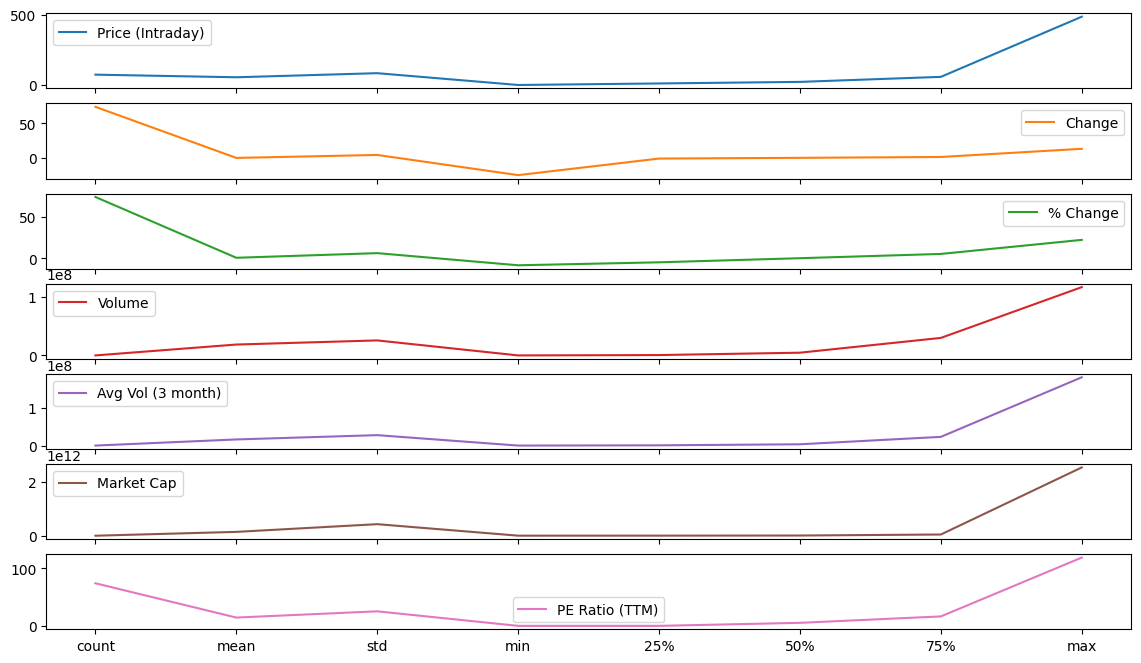

In [39]:

stocks_df.describe().plot(subplots=True, figsize=(14,8))
print(stocks_df.describe())

At the time of doing data analysis, Bank was a hot topic, thus I wanted to see how many bank stocks are in the list. By looking at data i noticed that some bank uses 'Banc' and some uses 'Bank', so to make it easier I searched for Ban. 

In [40]:
# find all rows that have 'Ban' in its name column?
stocks_df.loc[stocks_df.Name.str.contains('(?i)Ban', regex=True)]

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
6,BAC,Bank of America Corporation,27.14,0.1700,0.63,96333000.0,53081000.0,2.171000e+11,8.45
8,BBD,Banco Bradesco S.A.,2.41,0.0300,1.26,35934000.0,36395000.0,2.564800e+10,6.69
18,DB,Deutsche Bank Aktiengesellschaft,9.35,-0.3000,-3.11,36731000.0,5055000.0,2.068000e+10,3.88
20,EBKDY,Erste Group Bank AG,15.23,-0.8900,-5.50,24166.0,44552.0,1.243700e+10,5.62
21,EGFEY,Eurobank Ergasias Services and Holdings S.A.,0.64,-0.0589,-8.43,25725.0,43229.0,4.784000e+09,3.76
24,FRC,First Republic Bank,12.36,-0.1700,-1.36,72124000.0,25343000.0,2.302000e+09,1.48
32,INDB,Independent Bank Corp.,67.90,3.1700,4.90,439956.0,269904.0,3.060000e+09,11.47
36,ITUB,Itaú Unibanco Holding S.A.,4.37,0.0901,2.11,28187000.0,32538000.0,4.271600e+10,7.53
56,PPERY,PT Bank Mandiri (Persero) Tbk,14.04,0.7300,5.45,38853.0,95372.0,3.364200e+10,12.00
71,WAL,Western Alliance Bancorporation,33.05,1.8000,5.76,10422000.0,5760000.0,3.623000e+09,3.01


Get all the rows where volume is at least 20 million and the daily change is at least -5?

In [41]:
volume_change = stocks_df.query('Volume >= 20000000 and Change <= -5')[['Name', 'Change', 'Volume']]
volume_change

,Name,Change,Volume


Find stocks that dropped below 25% and print its symbol, name and % Change ?

In [42]:
stocks_below_25 = stocks_df.query('`% Change` < -25')[['Symbol', 'Name', '% Change']]
stocks_below_25

,Symbol,Name,% Change


Any stocks that performed over 10% today and how many times they transacted today?

In [43]:
stocks_above_20 = stocks_df.query('`% Change` > 10')[['Symbol', 'Name', '% Change', 'Volume']]
stocks_above_20

,Symbol,Name,% Change,Volume
30,HSAI,Hesai Group,15.11,328974.0
57,PROK,ProKidney Corp.,15.25,432713.0
61,RNW,ReNew Energy Global Plc,22.10,3928000.0


In [44]:

Symbol_s = stocks_df.loc[(stocks_df['PE Ratio (TTM)']>=5) & (stocks_df['Change']<= 5) & (stocks_df['Symbol'].str.startswith('S')),['Symbol', 'Name']]
Symbol_s

,Symbol,Name
63,SCHW,The Charles Schwab Corporation
64,SMPL,The Simply Good Foods Company


Is there any company that has Market Cap of 100 Billion or more? print only name and market cap.

In order to filter a DataFrame column that has spaces with the query method, we wrap the column using backticks. While this may not look great, it does allow us to use any column in the method.


In [45]:
large_market_cap = stocks_df.query("`Market Cap` > 100000000000")[['Name', 'Market Cap']]
#print(large_market_cap)

fig = px.bar(large_market_cap, x='Name', y='Market Cap', title='Largest Companies by Market Cap')
fig.show()


## Feature 3: Visualize/Present your data.

Ultimately, I wanted to find out the top 5 companies by its Volume on a particular day and see how those stocks are performing for the past year. I am using yfinance library for this purpose. yfinance is a package designed to download historical stock data from Yahoo Finance. I am visualizing my data thru plotly library.

In [46]:
top_5_company = stocks_df.nlargest(5,['Avg Vol (3 month)'])
top_5_company

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM)
68,TSLA,"Tesla, Inc.",190.41,-1.81,-0.94,116532000.0,180633000.0,6.024760e+11,50.51
0,AAPL,Apple Inc.,160.25,1.32,0.83,59256000.0,70659000.0,2.535000e+12,26.93
2,AMZN,"Amazon.com, Inc.",98.13,-0.58,-0.59,56145000.0,69249000.0,1.012000e+12,0.00
22,F,Ford Motor Company,11.51,0.09,0.79,71418000.0,68951000.0,4.588100e+10,0.00
1,AMD,"Advanced Micro Devices, Inc.",97.95,-2.33,-2.32,64691000.0,61474000.0,1.578360e+11,115.24


In [47]:
# taking a column and chaging it to a list
top_5_volume = (top_5_company.Symbol).to_list()
top_5_volume

['TSLA', 'AAPL', 'AMZN', 'F', 'AMD']

With the yfinance's download method, multiple ticker symbols can be downloaded at the same time. For my project I am passing in the list generated each time I run the file. Since, my project is not rigid and the data changes according to how stock market performs. I am downloading a data for 1y period, with an interval od 1d period, the stock market is open, it ignores the timezone.
If you want to remove Adjust Close Price column then you can do so by setting auto_adjust= True
You can download dividends and splits of stock by setting actions ='inline'. For my project, I am not using the dividends and the stock splits.

In [48]:
ticker = yf.download(top_5_volume, period='1y',interval='1d', ignore_tz=True, progress=False, auto_adjust=True )
ticker.info() # displays information about the columns
pd.set_option('display.max_columns', None) # displays all the columns with a scroll bar
ticker.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-25 to 2023-03-24
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   251 non-null    float64
 1   (Close, AMD)    251 non-null    float64
 2   (Close, AMZN)   251 non-null    float64
 3   (Close, F)      251 non-null    float64
 4   (Close, TSLA)   251 non-null    float64
 5   (High, AAPL)    251 non-null    float64
 6   (High, AMD)     251 non-null    float64
 7   (High, AMZN)    251 non-null    float64
 8   (High, F)       251 non-null    float64
 9   (High, TSLA)    251 non-null    float64
 10  (Low, AAPL)     251 non-null    float64
 11  (Low, AMD)      251 non-null    float64
 12  (Low, AMZN)     251 non-null    float64
 13  (Low, F)        251 non-null    float64
 14  (Low, TSLA)     251 non-null    float64
 15  (Open, AAPL)    251 non-null    float64
 16  (Open, AMD)     251 non-null    float64
 17  (Open, AMZN)    

Close                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-25  173.667984  119.669998  164.773499  15.081247  336.880005   
2022-03-28  174.542679  120.239998  168.990494  15.264383  363.946655   
2022-03-29  177.882431  123.230003  169.315002  16.253321  366.523346   
2022-03-30  176.699615  119.220001  166.300995  15.813792  364.663330   
2022-03-31  173.558640  109.339996  162.997498  15.484149  359.200012   

                  High                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-25  174.224610  121.400002  165.368500  15.365109  340.600006   
2022-03-28  174.671886  120.410004  169.037506  15.273540  365.959991   
2022-03-29  177.932118  123.709999  170.831497  16.299104  371.589996   
2022-03-30  178.528533  125.669998  168.950500  16.170907  371.316681   
2022-03-31  176.958045  116.379997  166.494995  15.887049  367.713318   

                   Low                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-25  171.709844  117.250000  162.250000  14.962210  332.440002   
2022-03-28  170.964349  116.709999  164.899994  14.907269  351.200012   
2022-03-29  175.278197  119.589996  167.868500  15.575718  357.703339   
2022-03-30  175.636051  118.589996  165.500000  15.749695  361.333344   
2022-03-31  173.349897  109.019997  162.953506  15.108720  358.880005   

                  Open                                                 \
                  AAPL         AMD        AMZN          F        TSLA   
Date                                                                    
2022-03-25  172.833045  119.919998  164.000000  15.328481  336.000000   
2022-03-28  171.133324  117.699997  164.975006  15.154501  355.033325   
2022-03-29  175.626095  122.279999  170.384003  15.575718  369.329987   
2022-03-30  177.474918  123.040001  168.509506  16.042712  363.723328   
2022-03-31  176.769187  116.309998  166.445007  15.749697  364.856659   

               Volume                                            
                 AAPL        AMD      AMZN         F       TSLA  
Date                                                             
2022-03-25   80546200   95852400  49032000  62023100   62031600  
2022-03-28   90371900   92966100  59854000  54634400  102506100  
2022-03-29  100589400   94143000  66154000  90676900   73614900  
2022-03-30   92633200   99476900  56168000  57853400   59865000  
2022-03-31  103049300  147004800  59966000  52529400   48992700

## Plotting Data


In [49]:
close = ticker.Close
close.info()
#close.head()
#print(close.describe())
max = close.max()
print(max)
min = close.min()
print(min)

#fig = px.line(close, title=f"Closing Price for stocks with largest volume on {today} for past 1y") 
#fig.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-03-25 to 2023-03-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    251 non-null    float64
 1   AMD     251 non-null    float64
 2   AMZN    251 non-null    float64
 3   F       251 non-null    float64
 4   TSLA    251 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB
AAPL    177.882431
AMD     123.230003
AMZN    169.315002
F        16.253321
TSLA    381.816681
dtype: float64
AAPL    124.829399
AMD      55.939999
AMZN     81.820000
F        10.194801
TSLA    108.099998
dtype: float64


In [50]:
high = ticker.High

figure = px.bar(high, title=f" High's for stocks with largest volume on {today} for past 1y")
figure.show()

In [51]:
low = ticker.Low
figure = px.line(ticker.Low, title=f"Low's for stocks with largest volume on {today} for past 1y", markers=True)
figure.show()

In [52]:
open = ticker.Open
open.describe()
px.area(open, title=f"Opening price for stocks with largest volume on {today} for past 1y")

In [53]:
volume = ticker.Volume
volume

print(volume.describe())
fig = px.scatter(volume, title=f"Volume for stock with largest volume on {today} for past 1y") 
fig.show()
#volume.plot(subplots=True, figsize=(10,18))


               AAPL           AMD          AMZN             F          TSLA
count  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02  2.510000e+02
mean   8.214708e+07  8.238279e+07  7.384840e+07  6.411718e+07  1.089275e+08
std    2.355073e+07  2.840417e+07  3.042191e+07  2.475065e+07  4.978153e+07
min    3.519590e+07  2.601890e+07  3.508860e+07  1.298090e+07  4.186470e+07
25%    6.767295e+07  6.260575e+07  5.496095e+07  5.049385e+07  7.244245e+07
50%    7.703370e+07  7.953200e+07  6.615400e+07  5.923820e+07  9.222660e+07
75%    9.014020e+07  9.555835e+07  8.392465e+07  7.390805e+07  1.404976e+08
max    1.826020e+08  2.253941e+08  2.726620e+08  2.497841e+08  3.065906e+08


array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

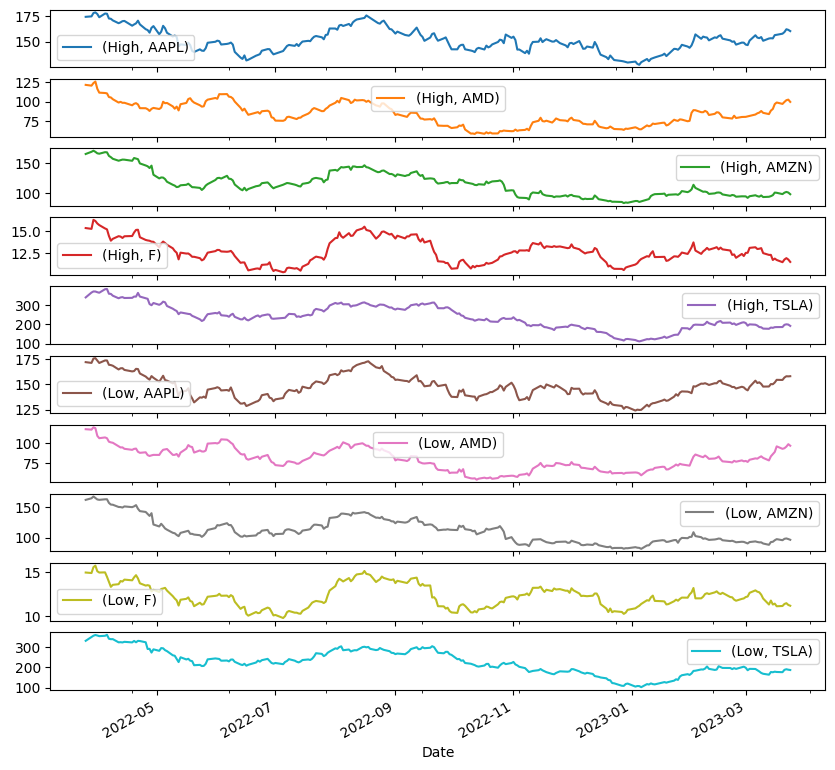

In [54]:
High_Low = ticker.loc[:, ['High', 'Low' ]]
High_Low.head()
High_Low.max()
High_Low.plot(subplots=True, figsize=(10,10))
#ax = High_Low.unstack(level=0).plot(figsize=(14,6))


## Feature 4: Best Practices.
Unit tests